In [1]:
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import tracemalloc
import sys
import multiprocessing as mp

In [2]:
from tqdm import tqdm

In [3]:
def random_parameter_generator(max,min,shape):
    rng = np.random.default_rng()
    array = (max - min) * rng.random(size=shape, dtype=np.float64) + min
    return array

def random_plasmid_parameter_range_generator(global_max_parameter_value,global_min_parameter_value,parameter_range_partition_size):
    rng = np.random.default_rng()
    parameter_range_size = parameter_range_partition_size * (global_max_parameter_value - global_min_parameter_value)
    min = (global_max_parameter_value - parameter_range_size - global_min_parameter_value) * rng.random(dtype=np.float64) + global_min_parameter_value
    max = min + parameter_range_size
    return min,max

In [4]:
def pcf(t, V, m_species, n_plasmids, growth_rates, species_niche_capacities, species_niches, transfer_rates, burdens, loss_rates, dilution_rate):
    S = V[:m_species]
    P = V[m_species:].reshape((m_species,n_plasmids))
    Pbar = np.repeat(np.expand_dims(P.T,1),m_species,axis=1)
    
    L = burdens
    Us = growth_rates
    D = dilution_rate
    K = loss_rates

    Sbar = np.repeat(S[...,np.newaxis],n_plasmids,axis=1)

    A = S/(S + np.einsum("ij,ij -> i",P,L))
    B = (Sbar*(1+L))/(Sbar*(1+L) + np.repeat(np.einsum("ij,ij -> i",P,L)[...,np.newaxis],n_plasmids,axis=1)-P*L)
    Up = np.repeat(Us[...,np.newaxis],n_plasmids,axis=1)/(1 + L)
    C = species_niche_capacities - species_niches @ S
    
    Cbar = np.repeat(C[...,np.newaxis],n_plasmids,axis=1)

    H = transfer_rates
    HPbar = np.einsum("ijk,ijk -> ji",H,Pbar)

    dSdt = (A*Us*S*C - D*S).flatten()
    dPdt = (B*Up*P*Cbar + (Sbar - P)*HPbar - D*P - K*P).flatten()
    dVdt = np.ones(len(V))

    dVdt[:m_species] = dSdt
    dVdt[m_species:] = dPdt

    return dVdt

In [5]:
def compute_pcf_m_species_n_plasmids(index, m_species, n_plasmids, target_plasmids, growth_rates, species_niche_capacities, species_niches, transfer_rates, burdens, loss_rates, dilution_rate,background_species_IC,background_plasmids_IC,timepoints,simulation_time,method):
    # Initial conditions
    V0 = np.zeros(m_species + m_species * n_plasmids)

    V0[:m_species] = background_species_IC
    V0[m_species+m_species*target_plasmids:] = background_plasmids_IC[:,:n_plasmids-target_plasmids].flatten()

    plasmids_IC = np.zeros((m_species,n_plasmids))

    plasmids_IC[:,target_plasmids:] = background_plasmids_IC[:,:n_plasmids-target_plasmids]

    target_plasmids_IC_unscaled = random_parameter_generator(1,0,(m_species,target_plasmids))
    target_plasmids_IC_scaled_to_species = target_plasmids_IC_unscaled * np.repeat(background_species_IC[...,np.newaxis],target_plasmids,axis=1)

    target_plasmids_scaling = random_parameter_generator(1,0,target_plasmids)

    target_plasmids_IC = target_plasmids_IC_scaled_to_species * np.repeat(target_plasmids_scaling[np.newaxis,...],m_species,axis=0)

    plasmids_IC[:,:target_plasmids] = target_plasmids_IC

    V0[m_species:] = plasmids_IC.flatten()

    # Time span for integration
    t_span = [0, simulation_time]

    # Solve the ODE system
    sol = solve_ivp(pcf, t_span, V0, method=method,args=(m_species, n_plasmids, growth_rates, species_niche_capacities, species_niches, transfer_rates, burdens, loss_rates, dilution_rate), t_eval=np.linspace(0, simulation_time, timepoints))

    time = sol.t
    species_biomass = sol.y[:m_species]
    total_biomass = sum(sol.y[:m_species])
    plasmid_distribution = sol.y[m_species:].reshape((m_species,n_plasmids,timepoints))

    plasmid_abundances = np.sum(plasmid_distribution,axis=0)
    target_plasmid_abundances = plasmid_abundances[:target_plasmids,:]
    
    return index,target_plasmid_abundances,plasmid_abundances,total_biomass,species_biomass,time

In [6]:
def merge(args):
    return compute_pcf_m_species_n_plasmids(*args)

In [12]:
save_data = True
path = "./pcf_simulations/"

n_replicates = 1
replicate_start = 1
for replicate in range(replicate_start,replicate_start+n_replicates):
    # Parameter values
    n_simulations = 10
    method = 'LSODA'

    m_species = 100
    n_plasmids = 5
    k_niches = 10

    initial_carrying_capacity = 1


    dilution_rate = 0.004
    timepoints = 50
    simulation_time = timepoints*24*7

    parameter_file_name = "./pcf/pcf_simulation_parameters_" + str(m_species) + "_species_" + str(n_plasmids) + "_plasmids_" + str(k_niches) + "_niches_" + "replicate_" + str(replicate)
    
    parameters = np.load(parameter_file_name+".npz")

    burdens=parameters['burdens']
    growth_rates=parameters['growth_rates']
    transfer_rates=parameters['transfer_rates']
    loss_rates=parameters['loss_rates']
    species_niche_capacities=parameters['species_niche_capacities']
    species_niches=parameters['species_niches']
    background_species_IC=parameters['background_species_IC']
    background_plasmids_IC=parameters['background_plasmids_IC']

    for target_plasmids in range(5,6):
        data = np.ones((n_simulations,target_plasmids+1,timepoints))
        full_data = np.ones((n_simulations,n_plasmids+m_species,timepoints))

        args = []
        for index in range(n_simulations):
            args.append([index,m_species, n_plasmids, target_plasmids, growth_rates, species_niche_capacities, species_niches, transfer_rates, burdens, loss_rates, dilution_rate, background_species_IC,background_plasmids_IC,timepoints,simulation_time,method])

        if __name__=="__main__":
            n_cpu = mp.cpu_count()-2
            print("cores:",n_cpu)
            pool = mp.Pool(processes=n_cpu)
            print("pool assigned")
            print("parallel computation started")
            pool = mp.Pool(processes=int(n_cpu-1))
            #for sim in pool.imap(merge,args):
            for sim in tqdm(pool.imap(merge, args), total=n_simulations):
                index,target_plasmid_abundances,plasmid_abundances,total_biomass,species_biomass,time = sim

                #print(target_plasmid_abundances)
                data[index,-1,:] = total_biomass
                data[index,:-1,:] = target_plasmid_abundances

                full_data[index,:n_plasmids,:] = plasmid_abundances
                full_data[index,n_plasmids:,:] = species_biomass

            pool.close()

        data_file_name = f"comm{replicate}_T{n_plasmids}"
        full_data_file_name = f"comm{replicate}_T{n_plasmids}_full"
        if save_data:
            np.save(path+data_file_name,data)
            np.save(path+full_data_file_name,full_data)

cores: 9
pool assigned
parallel computation started


100%|██████████| 10/10 [01:30<00:00,  9.07s/it]


Sample plot

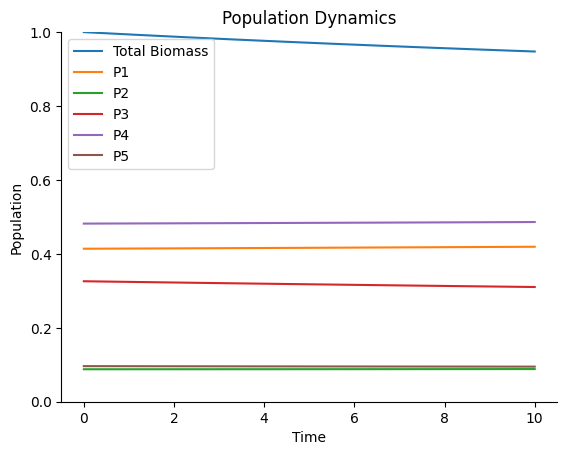

In [11]:
#print(plasmids_scaling)
sim = 1

data = np.load(path+f"comm1_T5.npy")
target_plasmids = 5

plt.plot(time, data[sim,-1,:], label=f"Total Biomass")
for plasmid in range(target_plasmids):
    plt.plot(time, data[sim,plasmid,:], label=f"P{plasmid+1}")

plt.xlabel("Time")  # Add x-axis label
plt.ylabel("Population")  # Add y-axis label
plt.title("Population Dynamics")  # Add title
plt.legend()  # Add legend
plt.grid(False)  # Remove grid lines


plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().set_ylim(0,1)

plt.show()